![kaggle_housesbanner](https://storage.googleapis.com/kaggle-media/competitions/kaggle/5407/media/housesbanner.png)

<h1 style="font-size: 1.8em; background-color: #CFB87C; padding: 0.8em">Predicting House Prices - Ames dataset</h1>

### Acknowledgments

The Ames Housing dataset was compiled by Dean De Cock with the intention of providing a rich and realistic dataset for the data science community.

Ames dataset:
https://jse.amstat.org/v19n3/decock/AmesHousing.txt

Ames data documentation:
https://jse.amstat.org/v19n3/decock/DataDocumentation.txt

This dataset has been used in a Kaggle competition: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

Photo by Tom Thain on Unsplash

Hyperparameter tuning for gradient boosting:
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

Hyperparameter tuning for xgboost:
* https://xgboost.readthedocs.io/en/release_0.82/parameter.html

* https://datascience.stackexchange.com/questions/108233/recommendations-for-tuning-xgboost-hyperparams

Plotting stack predictors:
https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import boxcox1p
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict, cross_validate
from sklearn.metrics import PredictionErrorDisplay
import xgboost as xgb

pd.set_option('display.float_format', lambda x: '%.3f' % x)

<h1 style="font-size: 1.8em; background-color: #CFB87C; padding: 0.8em">Problem Definition</h1>

This project uses the Ames Housing Dataset available at http://jse.amstat.org/v19n3/decock/AmesHousing.txt, which includes 79 features describing a wide range of characteristics of 2,930 homes in Ames, Iowa, USA, sold during the 2006 - 2010 timeframe.

Given the Ames Housing Data, our goal is to construct a predictive model capable of accurately estimating the sale prices of residential properties in Ames, Iowa. This model should be able to generalize well to unseen data and offer valuable insights into the key factors influencing housing prices in Ames, Iowa.

In [2]:
url = 'http://jse.amstat.org/v19n3/decock/AmesHousing.txt'
df = pd.read_csv(url, sep='\t')

<h1 style="font-size: 1.8em; background-color: #CFB87C; padding: 0.8em">Exploratory Data Analysis</h1>

In [3]:
# 2930 Observations, 79 Features (Excluding 'Order' and 'PID') and 1 target variable (SalePrice)
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.000,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.000,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
df.shape

(2930, 82)

### Data Documentation

| Variable | Description |
| --- | --- |
| Order (Discrete) | Observation number |
| PID (Nominal) | Parcel identification number |
| MS SubClass (Nominal) | Identifies the type of dwelling involved in the sale |	
| MS Zoning (Nominal) | Identifies the general zoning classification of the sale |
| Lot Frontage (Continuous) | Linear feet of street connected to property |
| Lot Area (Continuous) | Lot size in square feet |
| Street (Nominal | Type of road access to property |
| Alley (Nominal) | Type of alley access to property |
| Lot Shape (Ordinal) | General shape of property |
| Land Contour (Nominal) | Flatness of the property |		
| Utilities (Ordinal) | Type of utilities availablev
| Lot Config (Nominal) | Lot configuration |
| Land Slope (Ordinal) | Slope of property |
| Neighborhood (Nominal) | Physical locations within Ames city limits (map available) |
| Condition 1 (Nominal) | Proximity to various conditions |
| Condition 2 (Nominal) | Proximity to various conditions (if more than one is present) |
| Bldg Type (Nominal) | Type of dwelling |
| House Style (Nominal) | Style of dwelling |
| Overall Qual (Ordinal) | Rates the overall material and finish of the house |
| Overall Cond (Ordinal) | Rates the overall condition of the house |		
| Year Built (Discrete) | Original construction date |
| Year Remod/Add (Discrete) | Remodel date (same as construction date if no remodeling or additions) |
| Roof Style (Nominal) | Type of roof |
| Roof Matl (Nominal) | Roof material |		
| Exterior 1 (Nominal) | Exterior covering on house |
| Exterior 2 (Nominal) | Exterior covering on house (if more than one material) |
| Mas Vnr Type (Nominal) | Masonry veneer type |
| Mas Vnr Area (Continuous) | Masonry veneer area in square feet |
| Exter Qual (Ordinal) | Evaluates the quality of the material on the exterior | 
| Exter Cond (Ordinal) | Evaluates the present condition of the material on the exterior |
| Foundation (Nominal) | Type of foundation |
| Bsmt Qual (Ordinal) | Evaluates the height of the basement |
| Bsmt Cond (Ordinal) | Evaluates the general condition of the basement |
| Bsmt Exposure	(Ordinal) | Refers to walkout or garden level walls |
| BsmtFin Type 1 (Ordinal) | Rating of basement finished area |		
| BsmtFin SF 1 (Continuous) | Type 1 finished square feet |
| BsmtFinType 2	(Ordinal) | Rating of basement finished area (if multiple types) |
| BsmtFin SF 2 (Continuous) | Type 2 finished square feet |
| Bsmt Unf SF (Continuous) | Unfinished square feet of basement area |
| Total Bsmt SF (Continuous) | Total square feet of basement area |
| Heating (Nominal) | Type of heating |
| HeatingQC (Ordinal) | Heating quality and condition |
| Central Air (Nominal) | Central air conditioning |
| Electrical (Ordinal) | Electrical system |		
| 1st Flr SF (Continuous) | First Floor square feet |
| 2nd Flr SF (Continuous | Second floor square feet |
| Low Qual Fin SF (Continuous) | Low quality finished square feet (all floors) |
| Gr Liv Area (Continuous) | Above grade (ground) living area square feet |
| Bsmt Full Bath (Discrete) | Basement full bathrooms |
| Bsmt Half Bath (Discrete) | Basement half bathrooms |
| Full Bath (Discrete) | Full bathrooms above grade |
| Half Bath (Discrete) | Half baths above grade |
| Bedroom (Discrete) | Bedrooms above grade (does NOT include basement bedrooms) |
| Kitchen (Discrete) | Kitchens above grade |
| KitchenQual (Ordinal) | Kitchen quality |      	
| TotRmsAbvGrd	(Discrete) | Total rooms above grade (does not include bathrooms) |
| Functional (Ordinal) | Home functionality (Assume typical unless deductions are warranted) |
| Fireplaces (Discrete) | Number of fireplaces |
| FireplaceQu (Ordinal) | Fireplace quality |
| Garage Type (Nominal) | Garage location |		
| Garage Yr Blt (Discrete) | Year garage was built |		
| Garage Finish (Ordinal) | Interior finish of the garage |		
| Garage Cars (Discrete) | Size of garage in car capacity |
| Garage Area (Continuous) | Size of garage in square feet |
| Garage Qual (Ordinal) | Garage quality |		
| Garage Cond (Ordinal) | Garage condition |
| Paved Drive (Ordinal) | Paved driveway |
| Wood Deck SF (Continuous) | Wood deck area in square feet |
| Open Porch SF (Continuous) | Open porch area in square feet |
| Enclosed Porch (Continuous) | Enclosed porch area in square feet |
| 3-Ssn Porch (Continuous) | Three season porch area in square feet |
| Screen Porch (Continuous) | Screen porch area in square feet |
| Pool Area (Continuous) | Pool area in square feet |
| Pool QC (Ordinal) | Pool quality |
| Fence (Ordinal) | Fence quality |
| Misc Feature (Nominal) | Miscellaneous feature not covered in other categories |
| Misc Val (Continuous) | $ Value of miscellaneous feature |
| Mo Sold (Discrete) | Month Sold (MM) |
| Yr Sold (Discrete) | Year Sold (YYYY) |
| Sale Type (Nominal) | Type of sale |
| Sale Condition (Nominal) | Condition of sale |
| SalePrice (Continuous) | Sale price $$ |

### Checking for duplicates

In [5]:
n_unique_IDs = len(df['PID'].unique())
n_samples = df.shape[0]
n_duplicates = n_samples - n_unique_IDs
print('There are ' + str(n_duplicates) + ' duplicate IDs for ' + str(n_samples) + ' total observations')

There are 0 duplicate IDs for 2930 total observations


In [6]:
# Drop 'Order': Observation number and 'PID': Parcel identification number
df = df.drop(['Order', 'PID'], axis=1)

### Distribution of Features

We will examine the distribution of certain features typically deemed significant by homebuyers, such as the location, square footage, quality of the kitchen, and the age of the house.

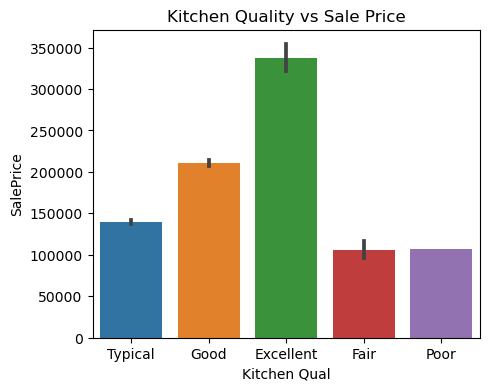

In [7]:
plt.rcParams["figure.figsize"] = (5, 4)
g = sns.barplot(data=df, x='Kitchen Qual', y='SalePrice')
g.set_xticklabels(['Typical', 'Good', 'Excellent', 'Fair', 'Poor'])
plt.title('Kitchen Quality vs Sale Price');

A Good or Excellent Kitchen Quality correspond to higher Sale Price. This seems to be an important feature in predicting sale price.

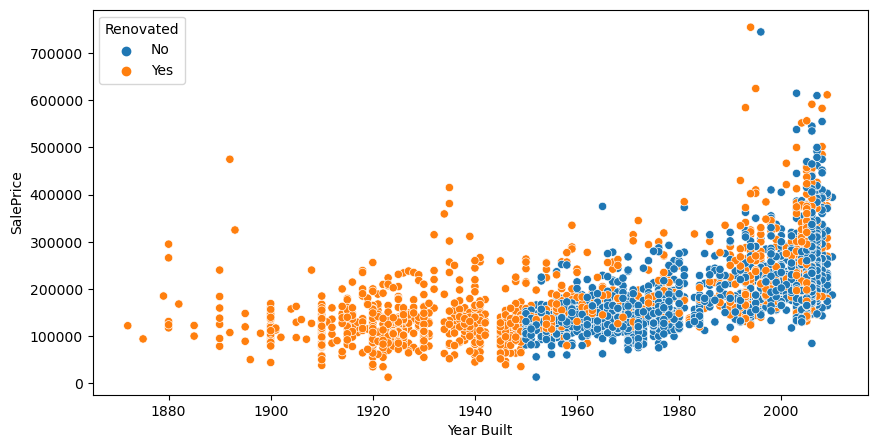

In [8]:
renovated = df['Year Built'] != df['Year Remod/Add']
renovated = renovated.replace({True: 'Yes', False: 'No'})

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='Year Built', y='SalePrice', hue=renovated)
plt.legend(title='Renovated', loc='upper left');

Newer houses tend to have higher prices, which is reasonable. All houses built before 1949 were renovated.

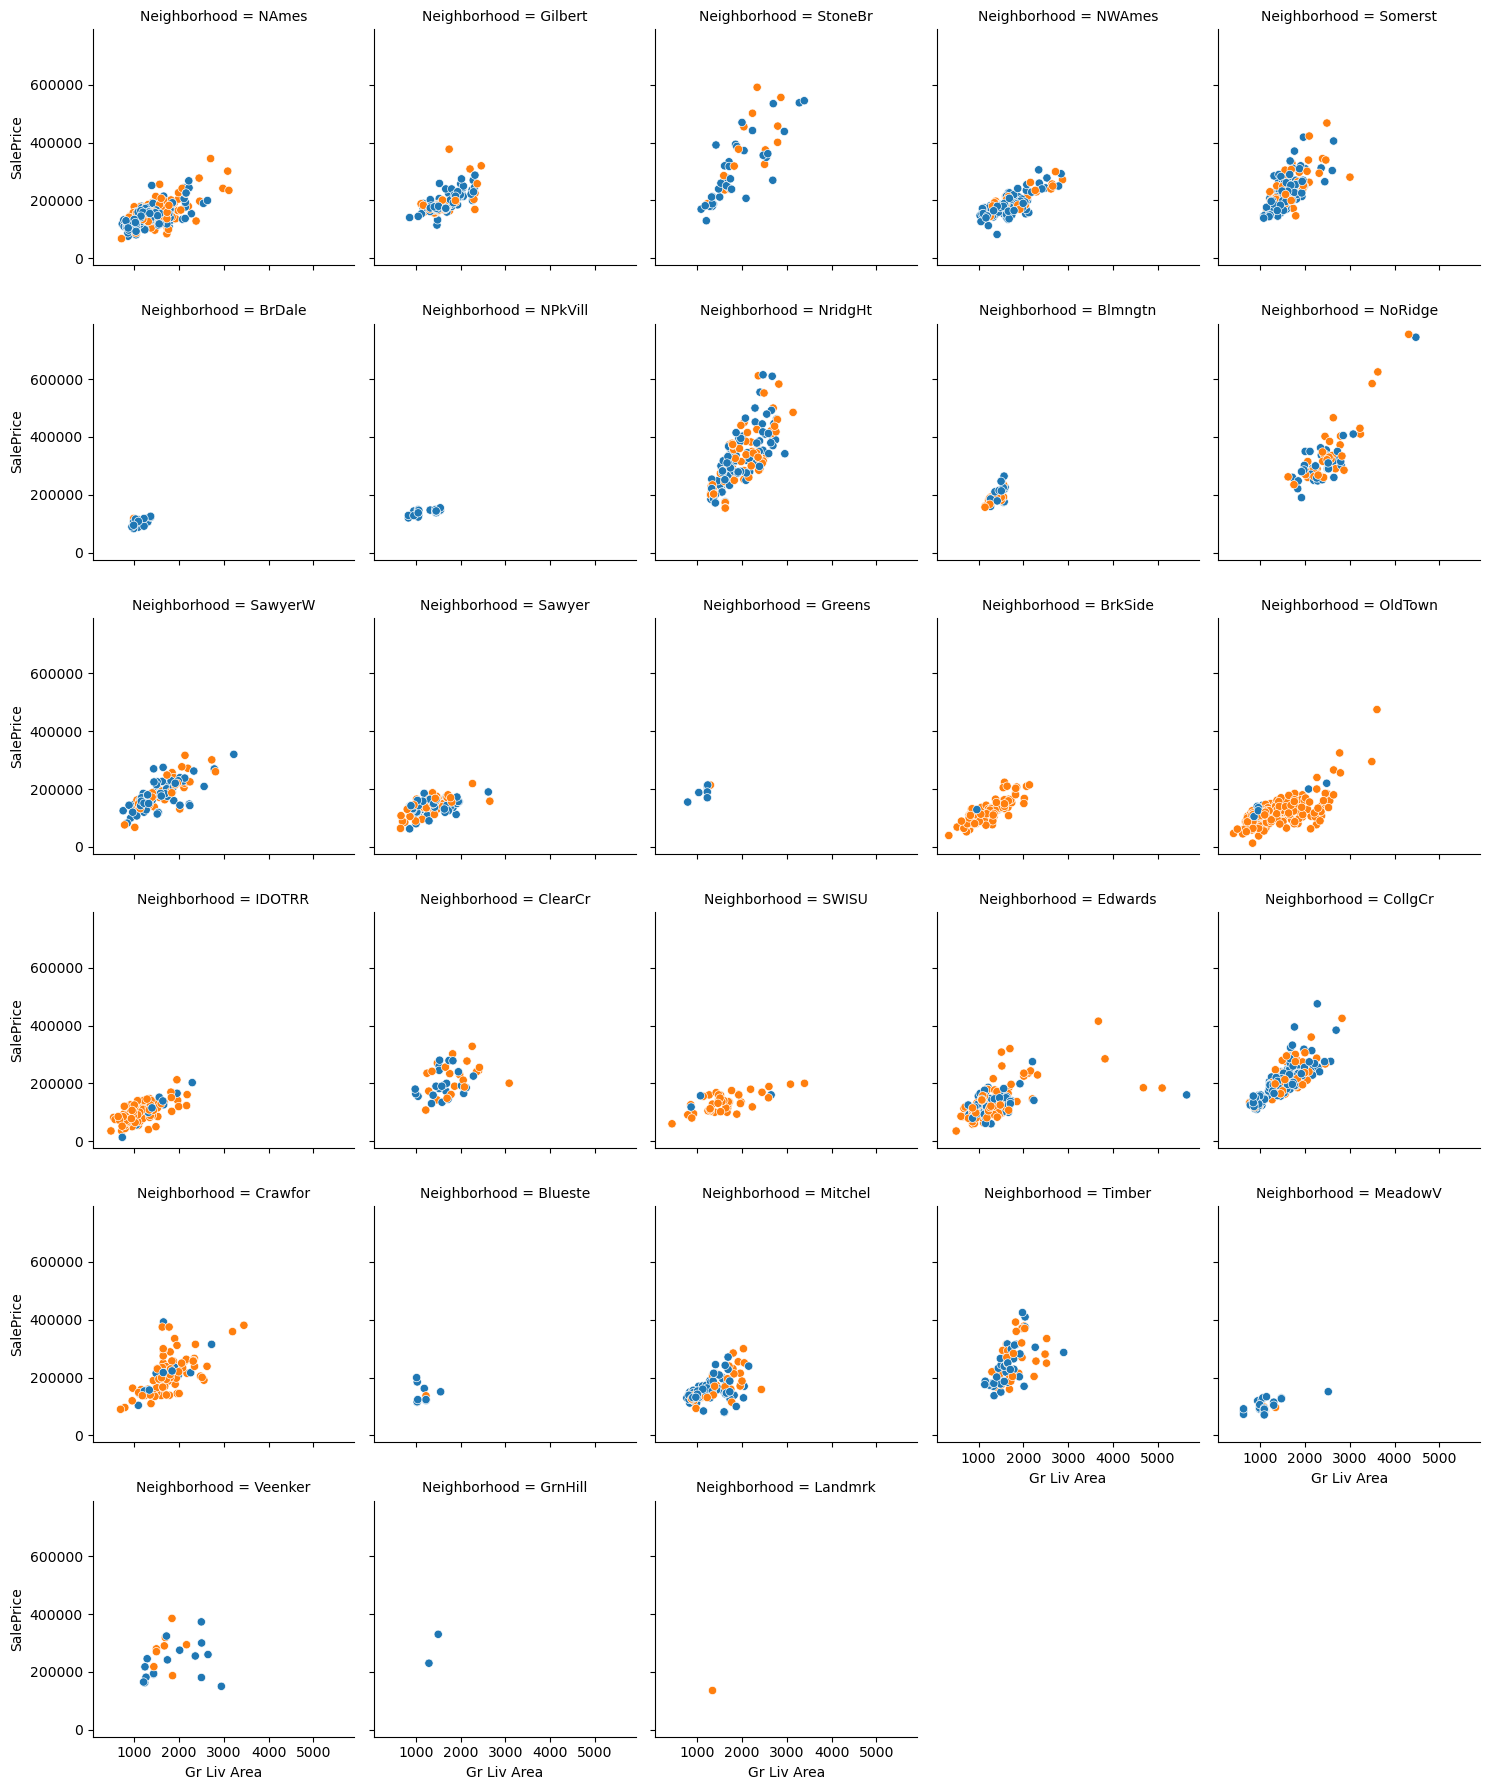

In [9]:
# Location by Neighborhood
g = sns.FacetGrid(df, col='Neighborhood', col_wrap=5)
g.map(sns.scatterplot, 'Gr Liv Area', 'SalePrice', hue=renovated);

Certain neighborhoods exhibit higher prices per square footage of above ground living area, suggesting that these areas may be more desirable, potentially influencing higher sale prices.

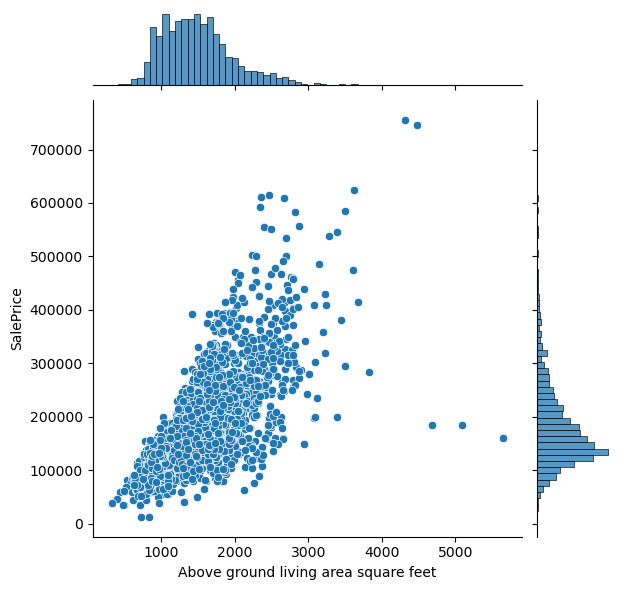

In [10]:
plt.rcParams["figure.figsize"] = (6, 4)
g = sns.jointplot(x='Gr Liv Area', y='SalePrice', data=df, palette='Blues')
g.ax_joint.set_xlabel('Above ground living area square feet')
plt.show();

The square footage of the living area appears to be another crucial factor in forecasting the sale price.

We observed potential outliers in the plots. Additionally, both the sale price and the above ground living area square feet distribution exhibit some skewness. We will need to address this issue later.

### Identifying outliers

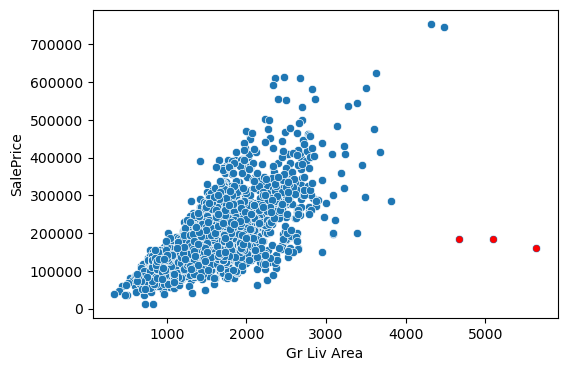

In [11]:
sns.scatterplot(data=df, x='Gr Liv Area', y='SalePrice')
plt.scatter(x=[5642, 5095, 4676], y=[160000, 183850, 184750], color='red', s=15);

In [12]:
# Get indices of the 3 outliers identified in the plot above, then drop them
idx_to_drop = df[(df['Gr Liv Area'] > 4000) & (df['SalePrice'] < 300000)].index.values
df = df.drop(idx_to_drop, axis=0)

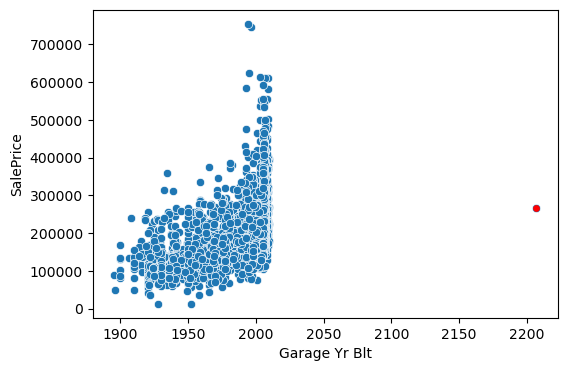

In [13]:
# Garage Yr Blt is 2207, which is an obvious error, and so we will drop this observation
sns.scatterplot(data=df, x='Garage Yr Blt', y='SalePrice')
plt.scatter(x=[2207], y=[267300], color='red', s=15);

In [14]:
idx_to_drop = df[df['Garage Yr Blt'] > 2023].index.values
df = df.drop(idx_to_drop, axis=0)

In [15]:
# Reset index since we removed some rows due to outliers
df = df.reset_index(drop=True)

In [16]:
# There's 1 more outlier that was identified by visualization from Lot Area, we will drop this row
df = df.drop([1554], axis=0)
df = df.reset_index(drop=True)

### Checking the distribution of the target variable

Skewness = 1.7455761044128677


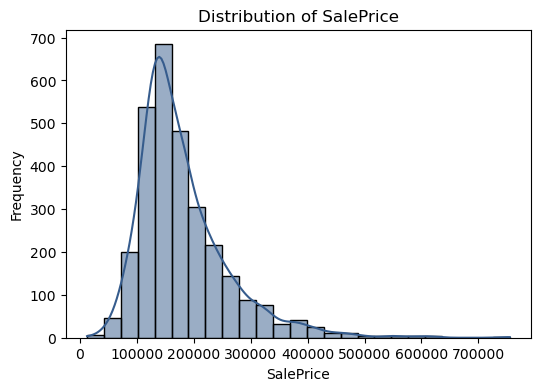

In [17]:
skewness = stats.skew(df['SalePrice'])
print('Skewness =', skewness)
sns.histplot(df['SalePrice'], kde=True, bins=25, color=sns.color_palette("viridis")[1])
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency');

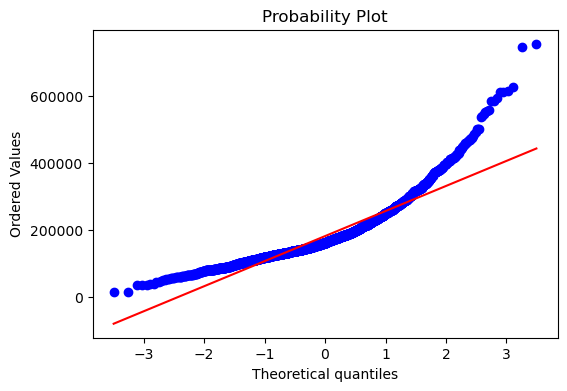

In [18]:
stats.probplot(df['SalePrice'], plot=plt);

Rule of thumb for skewness: 
* skewness absolute value between 0.5 and 1 are considered moderately skewed. 
* if the skewness is less than -1 or greater than 1, the data are highly skewed.

SalePrice distribution is quite skewed, and QQ plot clearly shows that it violates the normality assumption in Linear Regression. We will apply log transformation to make it more normally distributed. 

In [19]:
df['SalePrice'] = np.log(df['SalePrice'])

Skewness = -0.002737497715961243


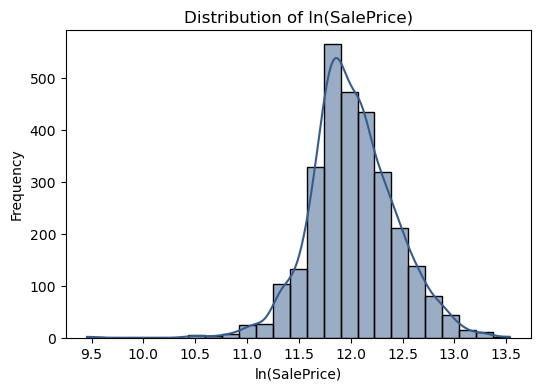

In [20]:
# Distribution after log transformation
skewness = stats.skew(df['SalePrice'])
print('Skewness =', skewness)
sns.histplot(df['SalePrice'], kde=True, bins=25, color=sns.color_palette("viridis")[1])
plt.title('Distribution of ln(SalePrice)')
plt.xlabel('ln(SalePrice)')
plt.ylabel('Frequency');

We will deal with skewness in features that have high correlation with target variable later.

<h1 style="font-size: 1.8em; background-color: #CFB87C; padding: 0.8em">Dealing with missing data</h1>

We will refer to data documentation when deciding what type of missing value imputation is best.

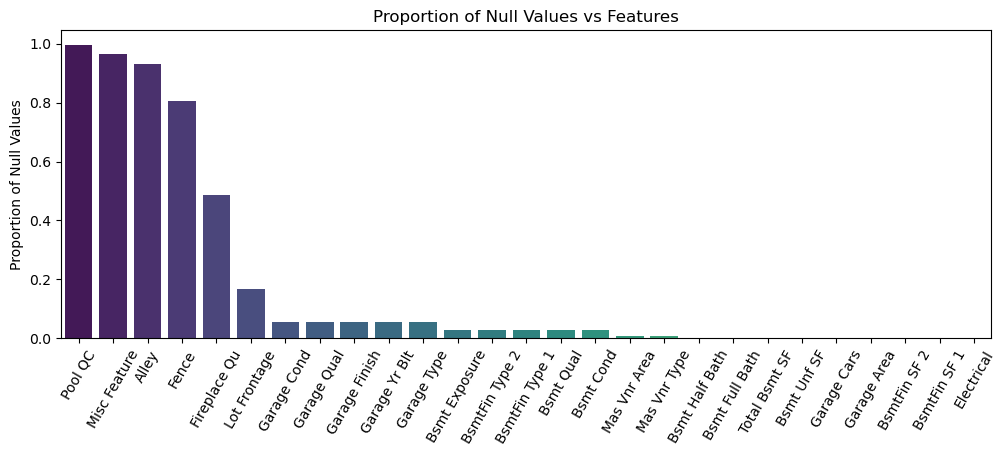

In [21]:
# Calculate number of null values per column
null_counts = df.isnull().sum()

# Filter out columns with zero null values, then sort
null_counts = null_counts[null_counts > 0] / df.shape[0]
null_counts = null_counts.sort_values(ascending=False)
plt.figure(figsize=(12, 4))
sns.barplot(x=null_counts.index, y=null_counts.values, palette='viridis')
plt.xticks(rotation=60)
plt.ylabel('Proportion of Null Values')
plt.title('Proportion of Null Values vs Features');

In [22]:
# Possible missing values
missing_vals = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']

In [23]:
for column in df:
    string_null = np.array([x in missing_vals[2:] for x in df[column]])
    if string_null.sum():
        print(column, ', string null:', string_null.sum(), '  isnull:', df[column].isnull().sum())

Mas Vnr Type , string null: 1751   isnull: 22


In [24]:
df['Mas Vnr Type'].unique()

array(['Stone', 'None', 'BrkFace', nan, 'BrkCmn', 'CBlock'], dtype=object)

We will replace nan with 'None' in 'Mas Vnr Type' since it most is likely means no masonry veneer.

Related to this feature is 'Mas Vnr Area'. We will replace missing values with 0.

In [25]:
df['Mas Vnr Type'] = df['Mas Vnr Type'].fillna('None')
df['Mas Vnr Area'] = df['Mas Vnr Area'].fillna(0)

We will drop 'Pool QC' and 'Misc Feature' since both have too many missing values and thus of little information to our predictive model. 

'Pool Area' and 'Misc Val' are related to 'Pool QC' and 'Misc Feature', and so will also also drop these two features.

In [26]:
df = df.drop(['Pool QC', 'Misc Feature', 'Pool Area', 'Misc Val'], axis=1)

'Alley': NA means No alley access

'Fence': NA means No Fence

'Fireplace Qu': NA means No Fireplace

In [27]:
df['Alley'] = df['Alley'].fillna('None')
df['Fence'] = df['Fence'].fillna('None')
df['Fireplace Qu'] = df['Fireplace Qu'].fillna('None')

Next, we will impute 'Lot Frontage' missing values with the median Lot Frontage of the neighborhood since it is most likely similar to other houses in its neighborhood.

In [28]:
df["Lot Frontage"] = df.groupby("Neighborhood")["Lot Frontage"].transform(lambda value: value.fillna(value.median()))

In [29]:
# There are still missing values, upon further checking there are 2 neighborhoods with no Lot Frontage information at all.
df["Lot Frontage"].isna().sum()

3

In [30]:
# These 2 neighborhoods does not have Lot Frontage information, will replace na with median value of all Lot Frontage
df[df['Neighborhood'] == 'GrnHill']['Lot Frontage']

2252   NaN
2887   NaN
Name: Lot Frontage, dtype: float64

In [31]:
df[df['Neighborhood'] == 'Landmrk']['Lot Frontage']

2783   NaN
Name: Lot Frontage, dtype: float64

In [32]:
df.loc[[2252, 2887, 2783], 'Lot Frontage'] = df['Lot Frontage'].median()

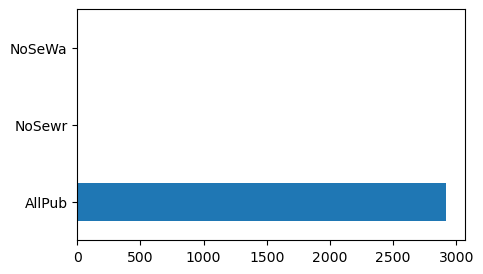

In [33]:
_, ax = plt.subplots(figsize=(5, 3))
df['Utilities'].value_counts().plot.barh(ax=ax);

In [34]:
df[df['Utilities'] == 'NoSeWa']

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Fence,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
955,20,RL,82.500,14375,Pave,None,IR1,Lvl,NoSeWa,CulDSac,...,118,0,0,233,None,1,2009,COD,Abnorml,11.831


In [35]:
# Since almost all values in 'Utilities' are AllPub, it is of little information in predictive model, we will drop this feature
df = df.drop('Utilities', axis=1)

In [36]:
# Replace missing values with 'None'
for feature in ['Garage Cond', 'Garage Qual', 'Garage Finish', 'Garage Type']:
    df[feature] = df[feature].fillna('None')

Replace missing values with 0 since it is likely means no garage, therefore zero Garage Area and zero Cars in such garage.

In [37]:
for feature in ['Garage Cars', 'Garage Area']:
    df[feature] = df[feature].fillna(0)

In [38]:
# Replace missing value with the min year, since it's likely means no garage and it's not reasonable to fill na with year 0.
df['Garage Yr Blt'] = df['Garage Yr Blt'].fillna(df['Garage Yr Blt'].min())

In [39]:
# Replace missing values with None since it's likely there is no basement
for feature in ['Bsmt Exposure', 'BsmtFin Type 2', 'Bsmt Qual', 'Bsmt Cond', 'BsmtFin Type 1']:
    df[feature] = df[feature].fillna('None')

In [40]:
# Replace missing values with zero for having no basement
for feature in ['Bsmt Full Bath', 'Bsmt Half Bath', 'Total Bsmt SF', 'Bsmt Unf SF',
               'BsmtFin SF 2', 'BsmtFin SF 1']:
    df[feature] = df[feature].fillna(0)

In [41]:
# Replace missing values with its mode
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

In [42]:
# Check if there is any remaining missing values
missing_vals = df.isna().sum()
missing_vals = missing_vals.drop(missing_vals[missing_vals == 0].index)
missing_vals

Series([], dtype: int64)

### Fix incorrect data type

In [43]:
df['Garage Yr Blt'].dtype

dtype('float64')

In [44]:
df['Garage Yr Blt'] = df['Garage Yr Blt'].astype(int)

<h1 style="font-size: 1.8em; background-color: #CFB87C; padding: 0.8em">Pairwise correlation of columns and Variance Inflation Factor</h1>

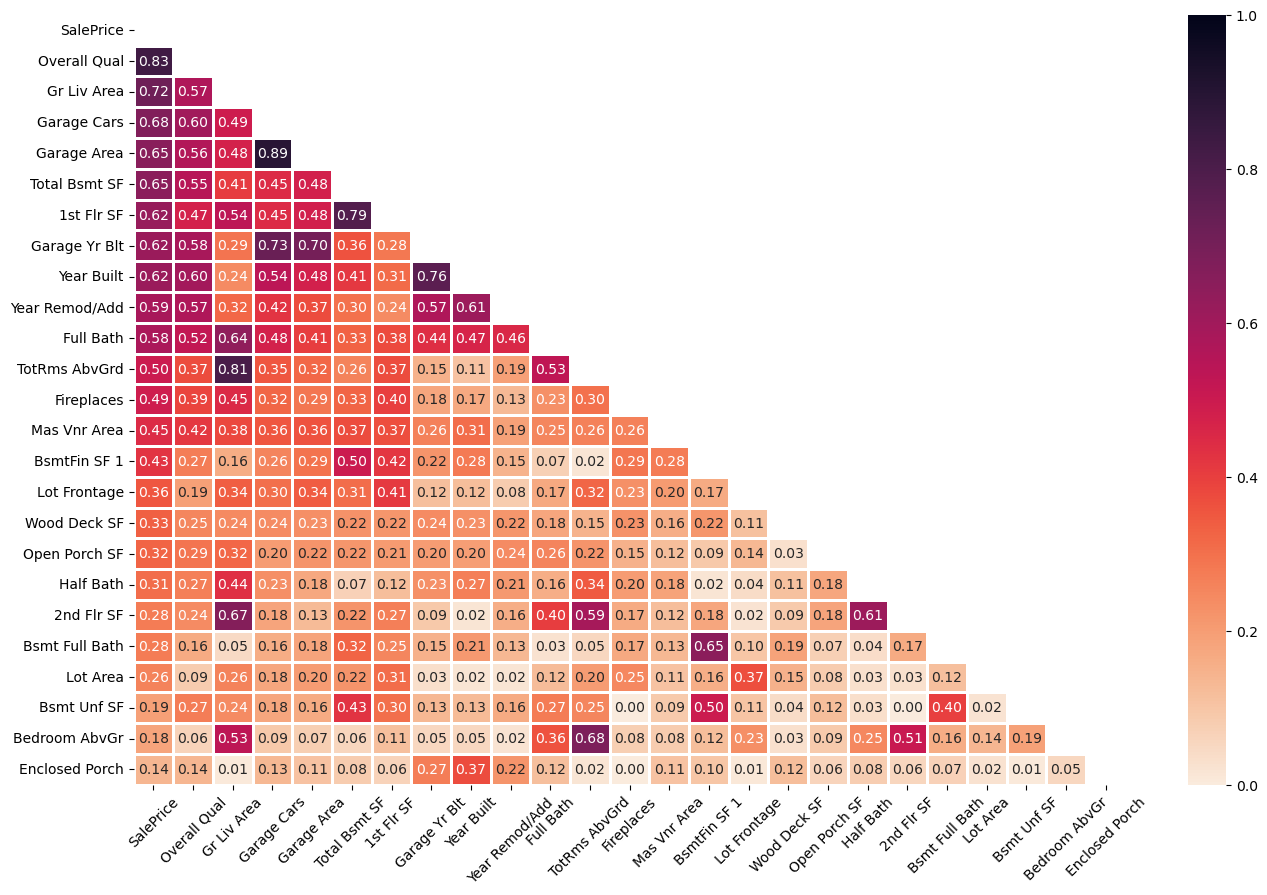

In [45]:
# Compute pairwise correlation of columns
corr_df = abs(df.select_dtypes(include=['number']).corr())

# select top 25 features that are highly correlated with SalePrice
top25 = corr_df['SalePrice'].sort_values(ascending=False)[:25]
top25_features = top25.index.tolist()
top25_df = corr_df.loc[top25_features, top25_features]

plt.figure(figsize=(16, 10))
mask = np.triu(np.ones_like(top25_df, dtype=bool))
g = sns.heatmap(top25_df, cmap='rocket_r', vmax=1, vmin=0, linewidths=1, linecolor='white',
            annot=True, fmt='.2f', mask=mask)
plt.xticks(rotation=45);

We see high correlation among features. For example GarageCars and GarageArea are highly correlated with corr coefficient of 0.89. We will drop GarageCars. 

Also noted high correlation between TotRms AbvGrd and Gr Liv Area. We will deal with this issue later with Variance Inflation Factor.

Consider model with regularization such as Lasso, as regularization is a very useful method to handle collinearity.

In [46]:
df = df.drop('Garage Cars', axis=1)

In [47]:
# Compute Variance Inflation Factor, return: sorted VIF in descending order
def VIF(X):
    vif_dict = {}
    df = X.select_dtypes('number').copy()
    for column in df:
        y = df[column]
        x = df.drop(column, axis=1)
        r_sqr = LinearRegression().fit(x, y).score(x, y)
        if r_sqr == 1:       # to prevent division by zero in the case of perfect collinearity
            r_sqr = r_sqr - 1e-5
        vif_dict[column] = 1 / (1 - r_sqr)        
    return pd.DataFrame({'VIF': vif_dict}).sort_values(by='VIF', ascending=False)   

In [48]:
# Notice that features related with square footage have perfect multicollinearity
VIF(df.drop(['SalePrice'], axis=1))

,VIF
1st Flr SF,100000.000
BsmtFin SF 1,100000.000
2nd Flr SF,100000.000
Gr Liv Area,100000.000
Total Bsmt SF,100000.000
BsmtFin SF 2,100000.000
Low Qual Fin SF,100000.000
Bsmt Unf SF,100000.000
Year Built,4.792
TotRms AbvGrd,4.346


Which collinear features to remove?

We will use sklearn.feature_selection mutual_info_regression to decide which feature to remove in order to reduce multicollinearity.

Quoted from Sklearn https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html:

"Mutual information between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency."

In short, it is the amount of information one variable gives about the other.

In [49]:
collinear_features = VIF(df.drop('SalePrice', axis=1))[:8].index.tolist()
X = df[collinear_features]
y = df['SalePrice']
mi = mutual_info_regression(X, y)
mi_df = pd.DataFrame({'MI': mi}, index=X.columns).sort_values(by='MI', ascending=False)
mi_df

,MI
Gr Liv Area,0.494
Total Bsmt SF,0.398
1st Flr SF,0.375
2nd Flr SF,0.206
BsmtFin SF 1,0.178
Bsmt Unf SF,0.115
BsmtFin SF 2,0.006
Low Qual Fin SF,0.006


Drop Low Qual Fin SF, BsmtFin SF 2 and 2nd Flr SF to reduce multicollinearity. We noticed earlier that 2nd Flr SF is highly correlated with Gr Liv Area.

In [50]:
df = df.drop(['Low Qual Fin SF', 'BsmtFin SF 2', '2nd Flr SF'], axis=1)

In [51]:
# Re check VIF
VIF(df.drop('SalePrice', axis=1)).head(10)

,VIF
Total Bsmt SF,9.885
Bsmt Unf SF,8.145
BsmtFin SF 1,7.805
Gr Liv Area,7.477
Year Built,4.778
1st Flr SF,4.412
TotRms AbvGrd,4.339
Garage Yr Blt,4.238
Overall Qual,3.156
Garage Area,2.907


That's a lot better!

A rough rule of thumb is that the VIFs greater than 10 give some cause for concern.

<h1 style="font-size: 1.8em; background-color: #CFB87C; padding: 0.8em">More Feature Engineering</h1>

Next, we will further  investigate features that have 0 mutual information with the target variable.

In [52]:
X = df.select_dtypes('number').drop('SalePrice', axis=1)
y = df['SalePrice']
mi = mutual_info_regression(X, y)
mi_df = pd.DataFrame({'MI': mi}, index=X.columns).sort_values(by='MI', ascending=False)
mi_df.tail(5)

,MI
Yr Sold,0.021
Screen Porch,0.013
Bsmt Half Bath,0.010
3Ssn Porch,0.000
Mo Sold,0.000


Does the specific month a house sold an important feature?

We know that information gain or mutual information measures how much information the presence/absence of a feature contributes to making prediction on the target variable.

Currently, it has 0 mutual information with the SalePrice. We'll take a look at its distribution plot.

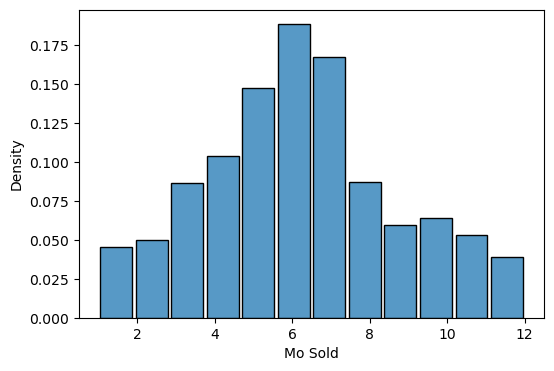

In [53]:
sns.histplot(data=df['Mo Sold'], stat='density', bins=12, shrink=0.9);

In [54]:
# If anova result is statistically significant => the feature is important to predict target
def anova(df, feature, target):
    groups = df[feature].unique()
    grouped_values = []
    for group in groups:
        if len(df[df[feature] == group]) < 1:
            print('Feature', feature)
        else:
            grouped_values.append(df[df[feature] == group][target])
    return stats.f_oneway(*grouped_values)

In [55]:
anova(df, 'Mo Sold', 'SalePrice')

F_onewayResult(statistic=1.4342025809957055, pvalue=0.15035755656905497)

In [56]:
anova(df, '3Ssn Porch', 'SalePrice')

F_onewayResult(statistic=0.8823426903241179, pvalue=0.6505671689744912)

I tried grouping Month Sold into new category to see if it can improve prediction. These months: 5, 6, 7 seem to have higher than normal sales. However upon further checking, it does not yield any improvement.

Upon checking the distributions of these very low mutual information features I decided to keep them for now.

### Dealing with skewed features

In [57]:
# Check the skewness of numerical features
numeric_df = df.select_dtypes(include=['number'])
skewed_features = numeric_df.apply(lambda x: stats.skew(x)).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewness': skewed_features})
skewness.head(10)

,Skewness
Lot Area,13.174
3Ssn Porch,11.388
Kitchen AbvGr,4.307
Enclosed Porch,4.018
Screen Porch,3.951
Bsmt Half Bath,3.951
Mas Vnr Area,2.598
Open Porch SF,2.493
Wood Deck SF,1.844
MS SubClass,1.356


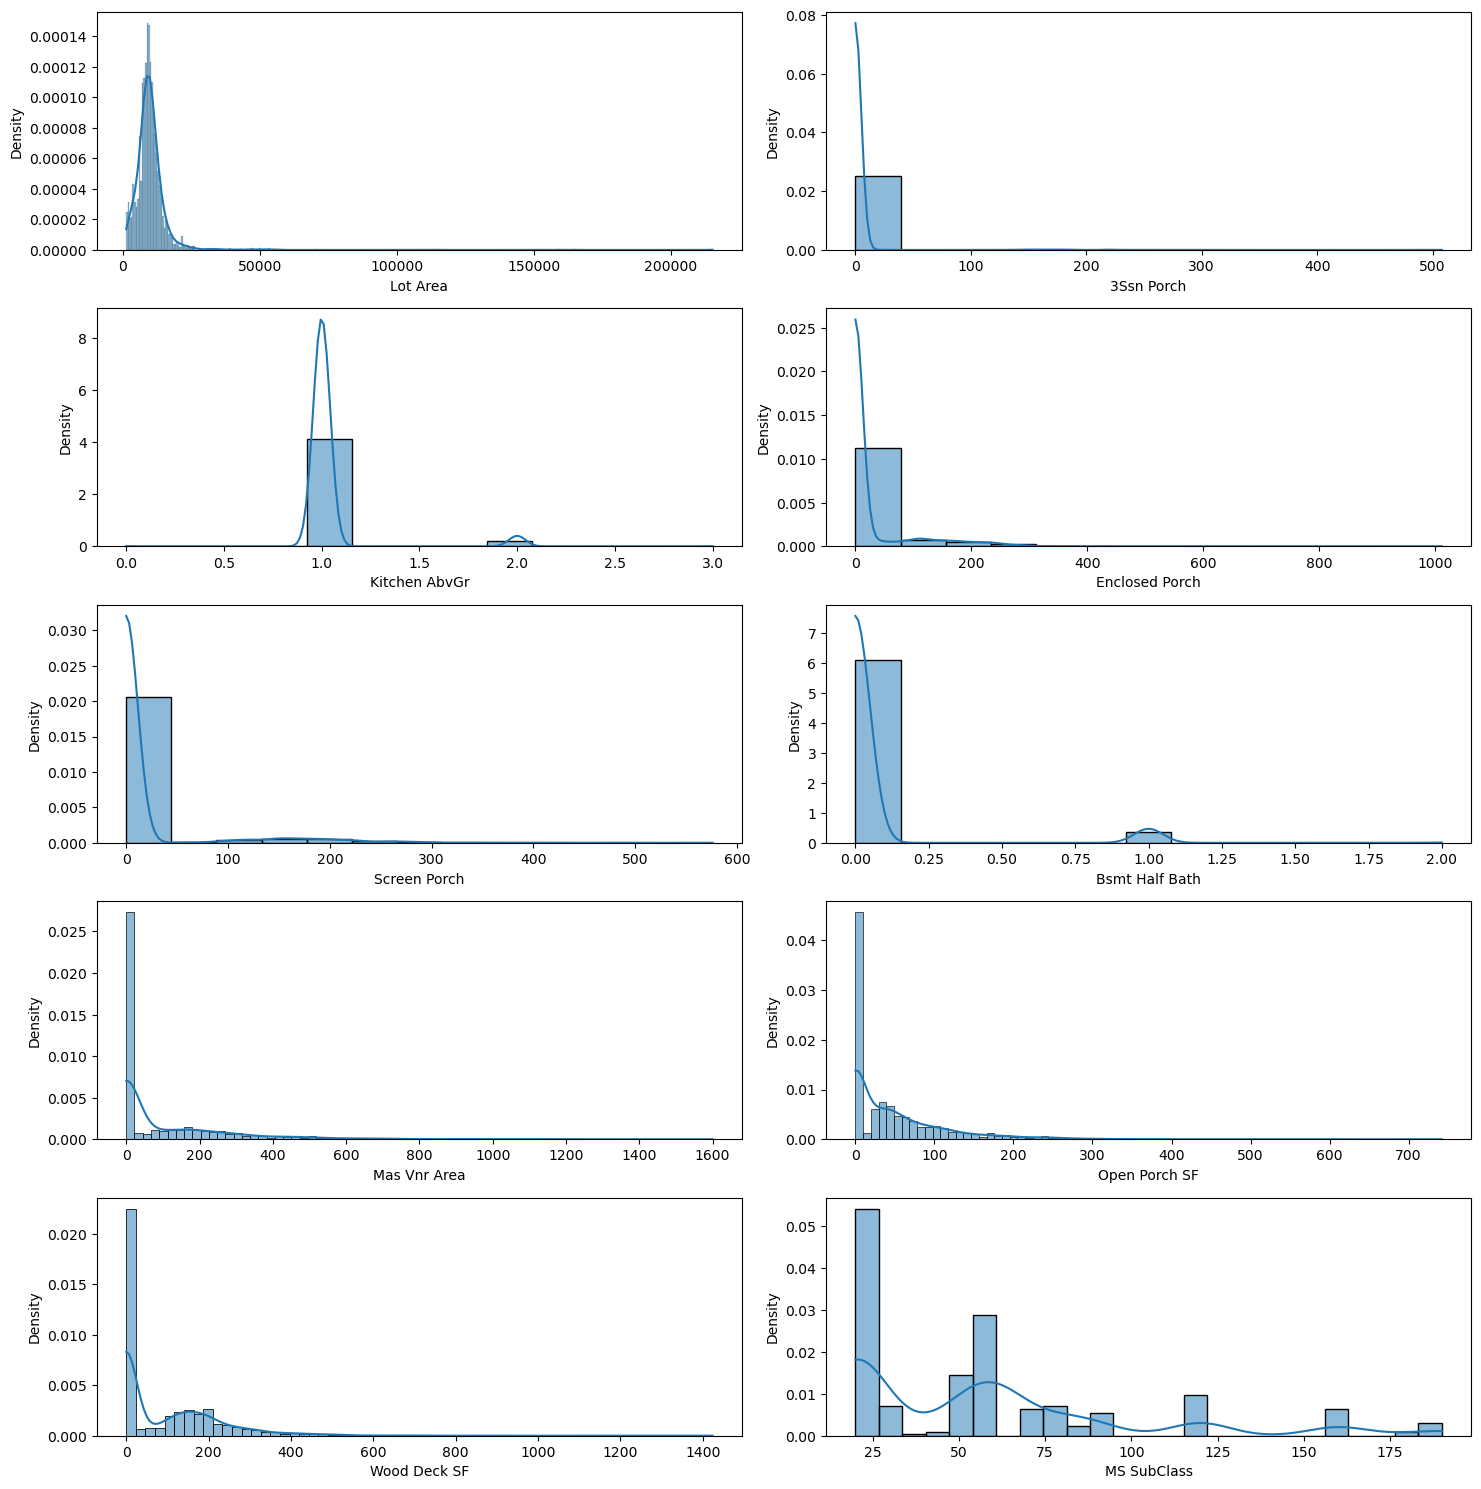

In [58]:
# Visualize distribution of features with high skewness
cols = skewness.index.tolist()[:10]

fig, axes = plt.subplots(5, 2, figsize=(15, 15))
axes = axes.ravel()
for col, ax in zip(cols, axes):
    sns.histplot(data=df[col], kde=True, stat='density', ax=ax)
fig.tight_layout()
plt.show()

Box Cox transformation of highly skewed features, using boxcox1p since the data contains zeros.

In [59]:
# set lambda to 0.15
skewness = skewness[abs(skewness) > 1]
skewed_features = skewness.index.tolist()
for feature in skewed_features:
    df[feature] = boxcox1p(df[feature], 0.15)
    
print("There are {} skewed numerical features that underwent BoxCox transformation.".format(skewness.shape[0]))

There are 31 skewed numerical features that underwent BoxCox transformation.


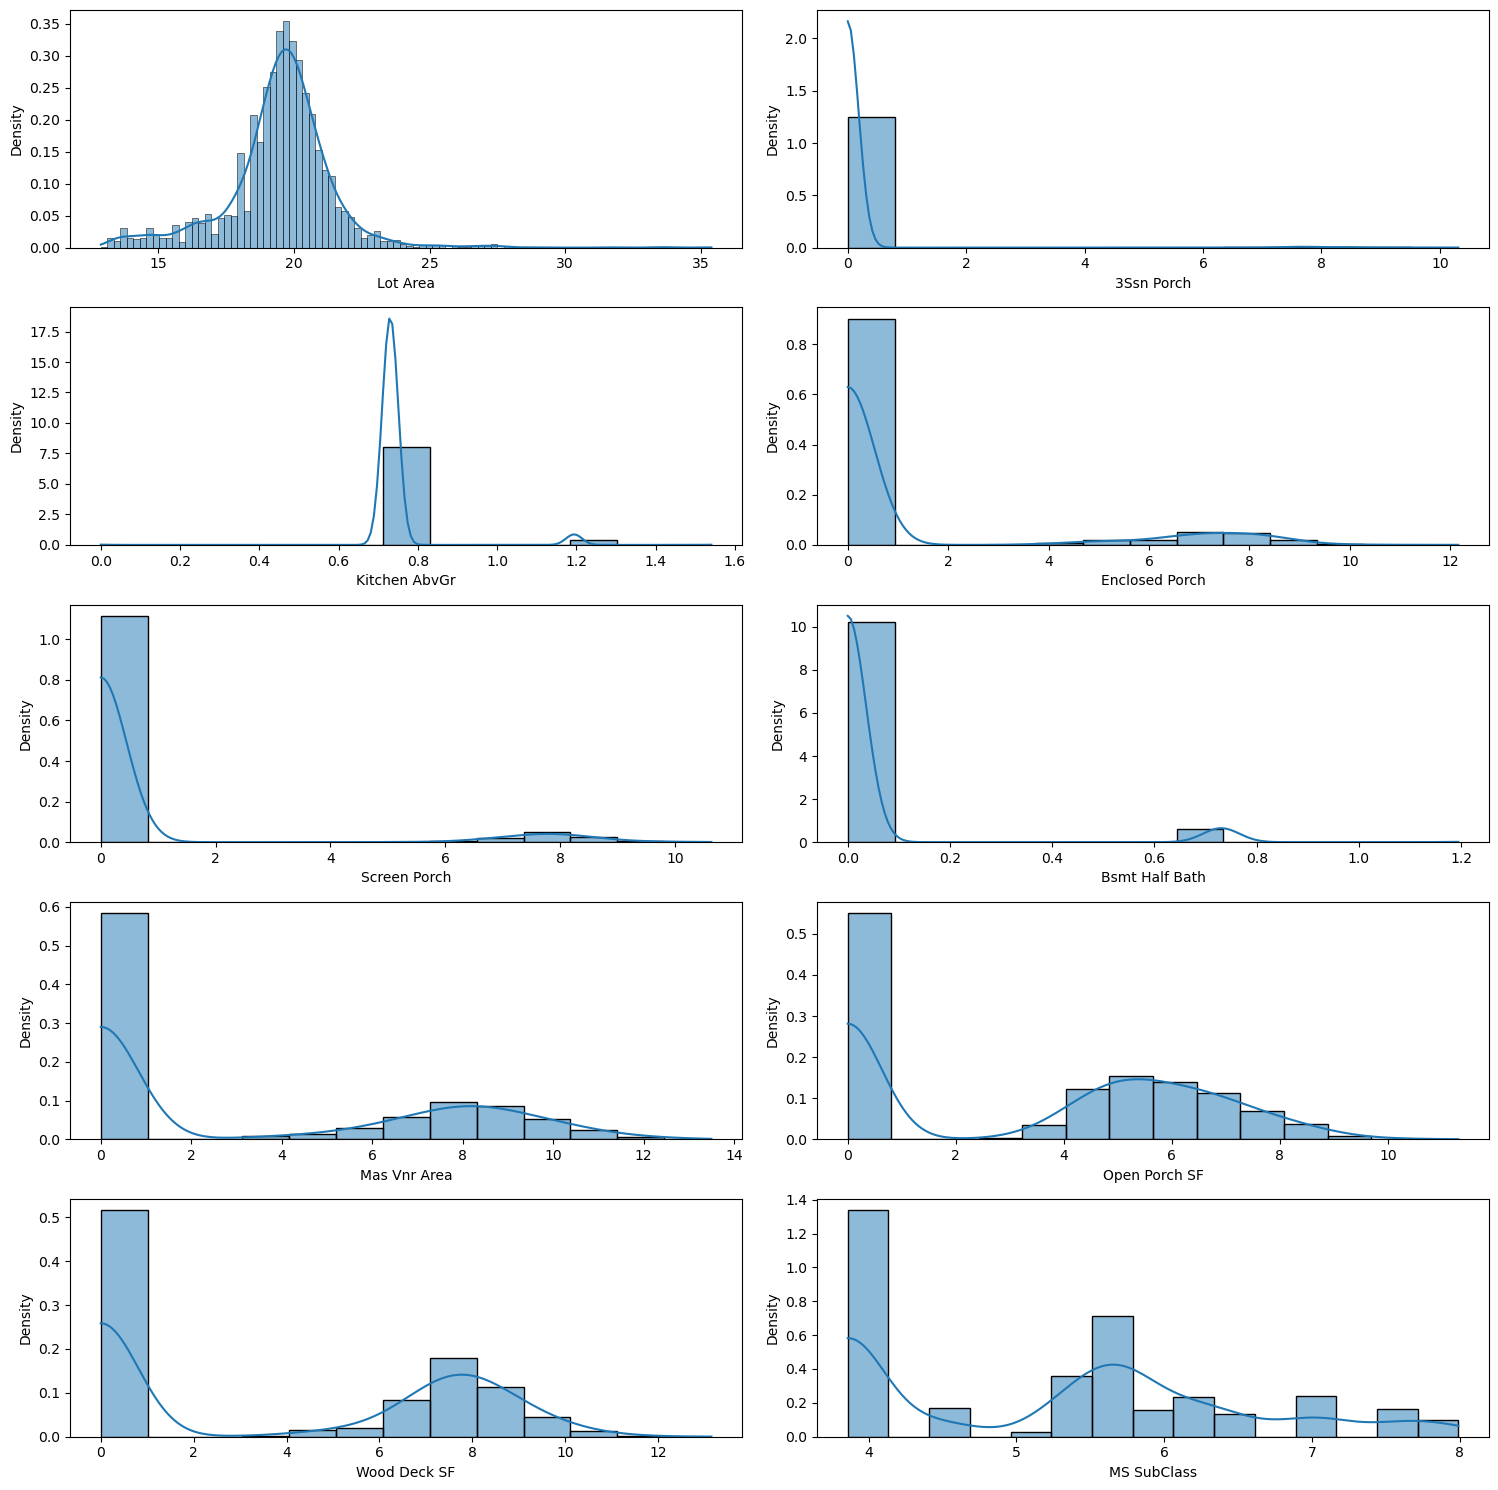

In [60]:
# Plot the distribution after Box Cox transformation
fig, axes = plt.subplots(5, 2, figsize=(15, 15))
axes = axes.ravel()
for col, ax in zip(cols, axes):
    sns.histplot(data=df[col], kde=True, stat='density', ax=ax)
fig.tight_layout()
plt.show()

<h1 style="font-size: 1.8em; background-color: #CFB87C; padding: 0.8em">Feature Encoding</h1>

First, we will divide categorical features into nominal and ordinal since different encoding method will be applied to them.

Some categorical features in our data are ordinal in nature, i.e. there is a natural ordering inherent. For example:

| Feature | 4 | 3 | 2 | 1 |
| --- | --- | --- | --- | --- |
|ExterQual | Excellent | Good | Average | Fair Poor |

Therefore, this type of feature will be encoded as an integer array.

Information on which nominal or ordinal features was given in data documentation:
https://jse.amstat.org/v19n3/decock/DataDocumentation.txt

In [61]:
categorical_features = df.select_dtypes(exclude=['number']).columns.tolist()

In [62]:
nominal = ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config', 
           'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 
           'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 
           'Central Air', 'Garage Type', 'Sale Type', 'Sale Condition']

In [63]:
ordinal = [x for x in categorical_features if x not in nominal]
print(ordinal)

['Lot Shape', 'Land Slope', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Fence']


Next, we will to encode nominal features with one hot encoding, and ordinal features with encode_ordinals from Sklearn

### One hot encoding nominal features

In [64]:
df_nominal_encoded = pd.get_dummies(df[nominal], drop_first=True)

### Encoding ordinal features

In [65]:
encoder = OrdinalEncoder()
df_ordinal_encoded = encoder.fit_transform(df[ordinal])
df_ordinal_encoded = pd.DataFrame(df_ordinal_encoded, columns=df[ordinal].columns)

### Combine nominal and ordinal features

In [66]:
df_categorical_encoded = pd.concat([df_nominal_encoded, df_ordinal_encoded], axis=1)

### Combine numerical and categorical features

In [67]:
df_numerical = df.select_dtypes(include='number').drop('SalePrice', axis=1)
df_features_encoded = pd.concat([df_numerical, df_categorical_encoded], axis=1)

<h1 style="font-size: 1.8em; background-color: #CFB87C; padding: 0.8em">Modelling</h1>

In [68]:
X = df_features_encoded
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [69]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [70]:
# Performance metric - Ref.: https://stackoverflow.com/questions/69432869/rmse-cross-validation-using-sklearn
def rmse_cv(regressor):
    rmse = -cross_val_score(regressor, X_train_scaled, y_train, scoring='neg_root_mean_squared_error',
                            cv=5, n_jobs=-1)
    return rmse.mean()

<h1 style="font-size: 1.4em; background-color: #A2A4A3; padding: 0.8em">Lasso</h1>

We will use Sklearn's LassoCV to find the optimal alpha for us. LassoCV will find alphas along the regularization path.

In [71]:
lasso = LassoCV(random_state=0, cv=10, n_jobs=-1)
lasso.fit(X_train_scaled, y_train)

LassoCV(cv=10, n_jobs=-1, random_state=0)

In [72]:
alpha_opt = lasso.alpha_

In [73]:
print('RMSE = ', rmse_cv(lasso))
print('R2 = ', lasso.score(X_test_scaled, y_test))

RMSE =  0.013630092872127122
R2 =  0.9224078060296111


<h1 style="font-size: 1.4em; background-color: #A2A4A3; padding: 0.8em">Ridge</h1>

In [74]:
# add alpha_opt from LassoCV to try
ridge = RidgeCV(alphas=(alpha_opt, 0.1, 1.0, 10.0, 12.0, 15.0))
ridge.fit(X_train_scaled, y_train)

RidgeCV(alphas=(6.894464012766597e-05, 0.1, 1.0, 10.0, 12.0, 15.0))

In [75]:
print('RMSE = ', rmse_cv(ridge))
print('R2 = ', ridge.score(X_test_scaled, y_test))

RMSE =  0.013694091554195573
R2 =  0.9257649304318818


<h1 style="font-size: 1.4em; background-color: #A2A4A3; padding: 0.8em">Random Forest</h1>

### Hyperparameter tuning

In [107]:
start_time = time.time()
params = { 'n_estimators': [1000, 1500, 1800, 2000], 
        'max_features': ['sqrt', None], 
        'max_depth': [15, None], 
        'max_leaf_nodes': [10, None], 
} 

grid_search = GridSearchCV(RandomForestRegressor(random_state=0), param_grid=params, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

elapsed_time = (time.time() - start_time)/60
print('GridSearchCV evaluation in {:.2f} minutes'.format(elapsed_time))

GridSearchCV evaluation in 13.83 minutes


In [108]:
grid_search.best_params_

{'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'n_estimators': 1500}

In [109]:
grid_search.best_score_

0.874965870187196

### Random Forest best model

In [76]:
rf = RandomForestRegressor(n_estimators=1800, max_features='sqrt', random_state=0)
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=1800, random_state=0)

In [77]:
print('RMSE = ', rmse_cv(rf))
print('R2 = ', rf.score(X_test_scaled, y_test))

RMSE =  0.01641810667358387
R2 =  0.9074330278224533


<h1 style="font-size: 1.4em; background-color: #A2A4A3; padding: 0.8em">Gradient Boosting</h1>

Reference: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

### Hyperparameter tuning

There's a trade off between learning_rate and n_estimators. As the base parameter, we will use GridSearchCV to select best combination of learning_rate and n_estimators.

In [175]:
start_time = time.time()
params = {
    'learning_rate': [0.01, 0.02, 0.03],
    'n_estimators': [3000, 4000, 5000, 6000]
}

grid_search = GridSearchCV(GradientBoostingRegressor(random_state=0), param_grid=params, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

elapsed_time = (time.time() - start_time)/60
print('GridSearchCV evaluation in {:.2f} minutes'.format(elapsed_time))

GridSearchCV evaluation in 19.16 minutes


In [176]:
grid_search.best_params_

{'learning_rate': 0.01, 'n_estimators': 5000}

In [177]:
grid_search.best_score_

0.9023722621816059

In [178]:
loss_func = ['squared_error', 'absolute_error', 'huber']
train_results = []
test_results = []

for ls in loss_func:
    model = GradientBoostingRegressor(loss=ls, n_estimators=5000, learning_rate=0.01, random_state=0)
    model.fit(X_train_scaled, y_train)
    score = model.score(X_train_scaled, y_train)
    train_results.append(score)
    score = model.score(X_test_scaled, y_test)
    test_results.append(score)

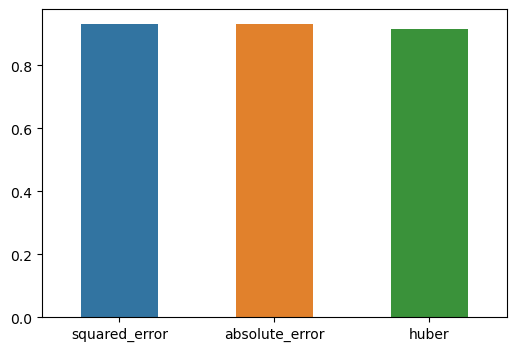

In [184]:
sns.barplot(x=loss_func, y=test_results, width=0.5);

The different loss functions are actually quite comparable in performance.

In [139]:
max_feats = ['sqrt', 'log2', None]
train_results = []
test_results = []

for maxFeat in max_feats:
    model = GradientBoostingRegressor(max_features=maxFeat, loss='absolute_error', n_estimators=5000,
                                      learning_rate=0.01, random_state=0)
    model.fit(X_train_scaled, y_train)
    score = model.score(X_train_scaled, y_train)
    train_results.append(score)
    score = model.score(X_test_scaled, y_test)
    test_results.append(score)

In [141]:
test_results

[0.936272373736345, 0.9338366991857215, 0.9304931648180275]

max_features 'sqrt' is optimal

In [146]:
maxDepths = [2, 3, 4, 5]
train_results = []
test_results = []

for maxDepth in maxDepths:
    model = GradientBoostingRegressor(max_depth=maxDepth, n_estimators=5000, learning_rate=0.01, max_features='sqrt',
                                     min_samples_leaf=10, min_samples_split=10, loss='huber', random_state=0)
    model.fit(X_train_scaled, y_train)
    score = model.score(X_train_scaled, y_train)
    train_results.append(score)
    score = model.score(X_test_scaled, y_test)
    test_results.append(score)

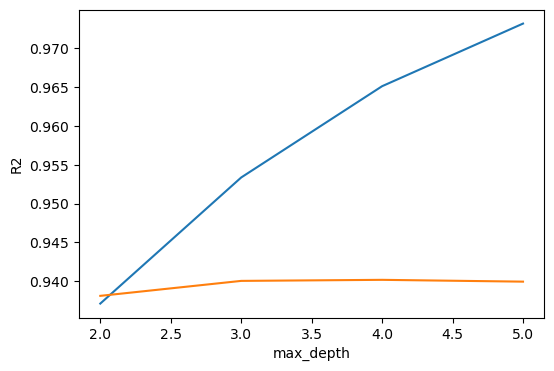

In [147]:
plt.plot(maxDepths, train_results, label='train')
plt.plot(maxDepths, test_results, label='test')
plt.xlabel('max_depth')
plt.ylabel('R2');

max_depth = 4 is optimal

### GradientBoostingRegressor best model

In [78]:
gboost = GradientBoostingRegressor(n_estimators=6000, learning_rate=0.01,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=0)
gboost.fit(X_train_scaled, y_train)

GradientBoostingRegressor(learning_rate=0.01, loss='huber', max_depth=4,
                          max_features='sqrt', min_samples_leaf=15,
                          min_samples_split=10, n_estimators=6000,
                          random_state=0)

In [79]:
print('RMSE = ', rmse_cv(gboost))
print('R2 = ', gboost.score(X_test_scaled, y_test))

RMSE =  0.013430079892952293
R2 =  0.9392796618917204


<h1 style="font-size: 1.4em; background-color: #A2A4A3; padding: 0.8em">XGBoost</h1>

Reference:

https://xgboost.readthedocs.io/en/release_0.82/parameter.html

https://datascience.stackexchange.com/questions/108233/recommendations-for-tuning-xgboost-hyperparams

### Hyperparameter tuning

In [50]:
# Step 1: tuning max_depth and min_child_weight
start_time = time.time()
params = {
    'max_depth': [2, 3, 4],
    'min_child_weight': [0, 1, 1.5, 1.8]
}

grid_search = GridSearchCV(xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, random_state=0), 
                           param_grid=params, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

elapsed_time = (time.time() - start_time)/60
print('GridSearchCV evaluation in {:.2f} minutes'.format(elapsed_time))

GridSearchCV evaluation in 1.43 minutes


In [51]:
grid_search.best_params_

{'max_depth': 2, 'min_child_weight': 0}

In [52]:
grid_search.best_score_

0.9060971671138407

In [54]:
# Step 2: tuning subsample and colsample_bytree, use the optimal tuning values found in step 1
start_time = time.time()
params = {
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.4, 0.5, 0.7, 1]
}

grid_search = GridSearchCV(xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, random_state=0,
                                           max_depth=2, min_child_weight=0), 
                           param_grid=params, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

elapsed_time = (time.time() - start_time)/60
print('GridSearchCV evaluation in {:.2f} minutes'.format(elapsed_time))

GridSearchCV evaluation in 0.83 minutes


In [55]:
grid_search.best_params_

{'colsample_bytree': 0.7, 'subsample': 1}

In [56]:
grid_search.best_score_

0.9087127287646194

In [63]:
# Step 3: tuning learning_rate and n_estimators, use the optimal tuning values found in step 1 & 2
start_time = time.time()
params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'n_estimators': [100, 500, 800, 1000, 1200, 2000]
}

grid_search = GridSearchCV(xgb.XGBRegressor(random_state=0, max_depth=2, min_child_weight=0,
                                           colsample_bytree=0.7, subsample=1), 
                           param_grid=params, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

elapsed_time = (time.time() - start_time)/60
print('GridSearchCV evaluation in {:.2f} minutes'.format(elapsed_time))

GridSearchCV evaluation in 1.54 minutes


In [64]:
grid_search.best_params_

{'learning_rate': 0.1, 'n_estimators': 800}

In [65]:
grid_search.best_score_

0.9087136913734222

### XGBoost best model

In [80]:
xgboost = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, random_state=0, max_depth=6, 
                           min_child_weight=0, colsample_bytree=1, subsample=1)
xgboost.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=0, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [81]:
print('RMSE = ', rmse_cv(xgboost))
print('R2 = ', xgboost.score(X_test_scaled, y_test))

RMSE =  0.014124248266048411
R2 =  0.926878979950117


<h1 style="font-size: 1.8em; background-color: #A2A4A3; padding: 0.8em">Stacking Regressor</h1>

Stacking Regressor is an ensemble learning technique that takes several regression models and uses their output as the input for the meta-regressor (final_estimator).

Stacking can sometimes outperform individual regressors by leveraging the strengths of different regression models.

After experimenting with different stacking configurations and cross validated the performance metrics, this combination of RidgeCV, GradientBoostingRegressor, RandomForestRegressor with LassoCV as the final estimator seems to work well with our data. And this will be our final model.

In [82]:
start_time = time.time()
estimators = [
    ('Ridge', ridge),
    ('Gradient Boost', gboost),
    ('Random Forest', rf)
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=lasso)
stacking_regressor.fit(X_train_scaled, y_train)

elapsed_time = (time.time() - start_time)/60
print('Stacking Regressor fitted in {:.2f} minutes'.format(elapsed_time))

Stacking Regressor fitted in 4.47 minutes


In [83]:
start_time = time.time()
stacked_rmse = rmse_cv(stacking_regressor)

elapsed_time = (time.time() - start_time)/60
print('Stacking Regressor RMSE Cross Validation evaluation in {:.2f} minutes'.format(elapsed_time))

Stacking Regressor RMSE Cross Validation evaluation in 6.11 minutes


In [84]:
print('RMSE = ', stacked_rmse)
print('R2 = ', stacking_regressor.score(X_test_scaled, y_test))

RMSE =  0.013075129772663363
R2 =  0.9383849018419689


<h1 style="font-size: 1.8em; background-color: #CFB87C; padding: 0.8em">Conclusion</h1>

Following data cleaning, feature engineering/selection to mitigate multicollinearity and address highly skewed features, as well as incorporating regularization techniques, we formulated our final model — the stacked regressors model — with the aim of enhancing the accuracy in predicting the Sale Price of houses within the Ames dataset. 

Cross validation of model performances (results displayed below) revealed that the stacked regressor model exhibited the most optimal performance.

The stacked regressors combine the strengths of the different single regressor. Nevertheless, a drawback is evident: the training process for the stacked regressor incurs significantly higher computational expenses.

Lastly, feature importances from our model can offer insights on what features are important in deciding house price (the corresponding plot is located below at the end). The top predictive features for our model appear quite reasonable. Leading the list are Overall Qual (the rates of the overall material and finish of the house), Gr Liv Area (Above ground living area square feet), followed by a range of features looking at the year built, total basement square feet, garage area, 1st floor square feet. The number of full bath, the quality of the exterior and the quality of the kitchen also play an important role in predicting the sale price.

### Cross Validation of Models Performances

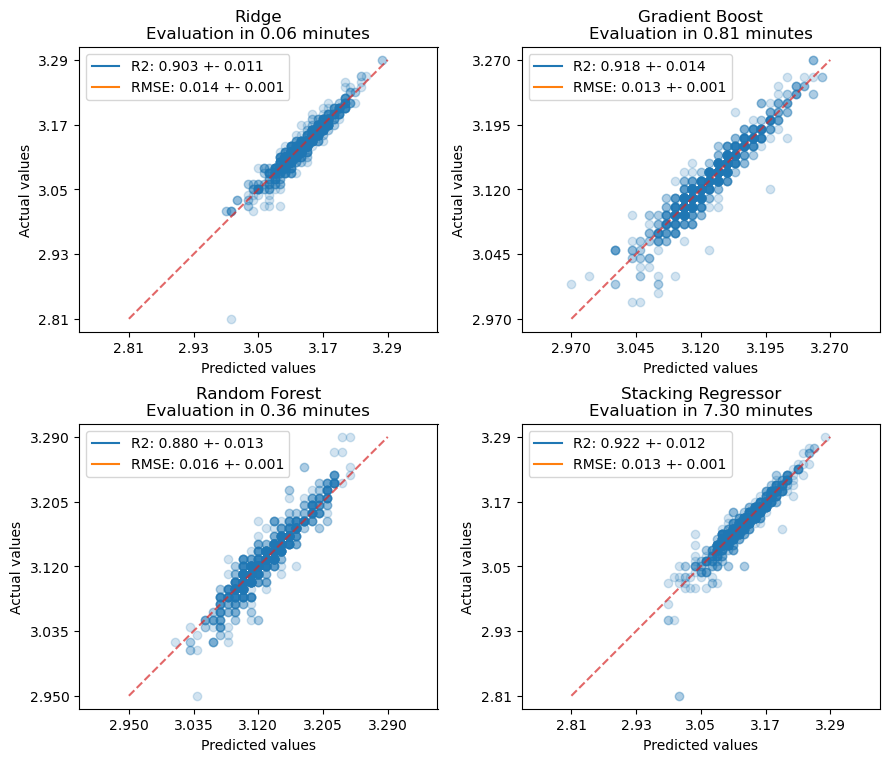

In [88]:
# Reference: https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html
fig, axs = plt.subplots(2, 2, figsize=(9, 8))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators + [('Stacking Regressor', stacking_regressor)]
):
    scorers = {'R2': 'r2', 'RMSE': 'neg_root_mean_squared_error'}

    start_time = time.time()
    scores = cross_validate(
        est, X, y, scoring=list(scorers.values()), n_jobs=-1, verbose=0
    )
    elapsed_time = (time.time() - start_time)/60

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)
    scores = {
        key: (
            f"{np.abs(np.mean(scores[f'test_{value}'])):.3f} +- "
            f"{np.std(scores[f'test_{value}']):.3f}"
        )
        for key, value in scorers.items()
    }

    display = PredictionErrorDisplay.from_predictions(
        y_true=np.round(y, 2),
        y_pred=np.round(y_pred, 2),
        kind='actual_vs_predicted',
        ax=ax,
        scatter_kwargs={'alpha': 0.2, 'color': 'tab:blue'},
        line_kwargs={"color": "tab:red"},
    )
    ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} minutes")

    for name, score in scores.items():
        ax.plot([], [], '', label=f"{name}: {score}")
    ax.legend(loc='upper left')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Residual Plot

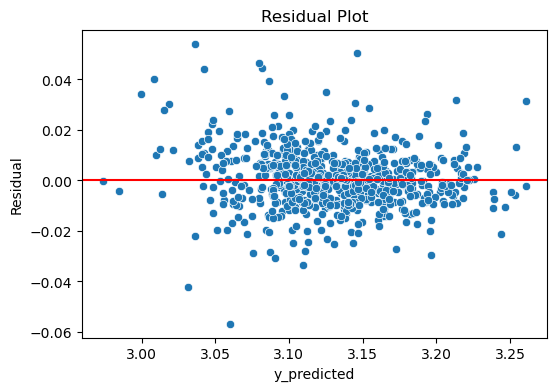

In [90]:
stacking_regressor_preds = stacking_regressor.predict(X_test_scaled)
resid = y_test - stacking_regressor_preds
df_resid = pd.DataFrame({'y_predicted': stacking_regressor_preds, 'Residual': resid})
ax = sns.scatterplot(data=df_resid, x='y_predicted', y='Residual')
ax.axhline(y=0, c='red')
plt.title('Residual Plot');

There is no definite pattern (something like linear or quadratic or funnel shaped) in the Residual plot. No violation of homoscedasticity assumption here.

Also, there is no evidence of autocorrelation here, there is no unexplained pattern due to the current value being dependent on the previous value.

Durbin Watson test to detect the present of autocorrelation:
* The statistics ranges from 0 to 4 with value of zero indicating no autocorrelation.
* Values between 1.5 to 2.5 generally show that there is no autocorrelation.

In [91]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(df_resid['Residual'])

2.003919739482287

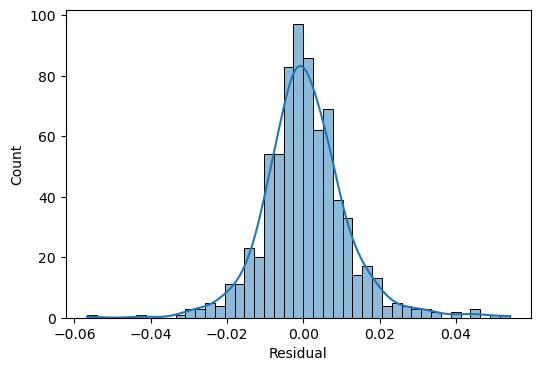

In [92]:
sns.histplot(df_resid['Residual'],kde=True);

No violation of the normality assumption on the error term/residuals.

### Feature Importance

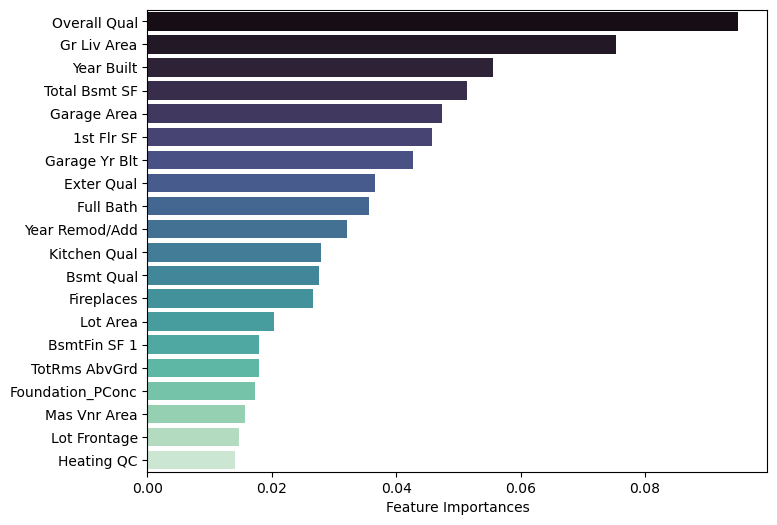

In [93]:
df_fi = pd.DataFrame({'Feature Importances': rf.feature_importances_}, index=X.columns)
df_fi_top20 = df_fi.sort_values(by='Feature Importances', ascending=False)[:20]
plt.figure(figsize=(8, 6))
sns.barplot(data=df_fi_top20, x='Feature Importances', y=df_fi_top20.index, orient='h', palette='mako');

The top predictive features for our model appear quite reasonable. Leading the list are Overall Qual (the rates of the overall material and finish of the house), Gr Liv Area (Above ground living area square feet), followed by a range of features looking at the year built, total basement square feet, garage area, 1st floor square feet. The number of full bath, the quality of the exterior and the quality of the kitchen also play an important role in predicting the sale price.